In [1]:
%matplotlib inline

In [2]:
import re

from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def get_param_value(arr, param):
    # Searches arr for the first item that starts with param and returns its (float) value.
    # Assumes items are a string concatenation of param and its value.
    # Ex. get_param_value(['k0.9'], 'k') returns 0.9.
    pattern = re.compile(f'{param}([0-9.]+)')
    for item in arr:
        match = pattern.match(item)
        if match is not None:
            return float(match.group(1))
    else:
        raise RuntimeError(f'Cannot find parameter {param} in array.')

def to_df(path, fname, params):
    filelist = path.glob(fname)
    d = {param: [] for param in params}
    d.update({'NDCG20':[], 'ERR20':[], 'map':[], 'P_30': []})
    for file in filelist:
        with open(file) as f:
            fvar = file.stem.split('_')
            for param in params:
                d[param].append(get_param_value(fvar, param))
            i = 0
            for line in f:
                i += 1
                if i == 52:
                    assert 'amean' in line
                    spl = line.split(',')
                    d['NDCG20'].append(float(spl[2].strip()))
                    d['ERR20'].append(float(spl[3].strip()))
                elif i == 53:
                    assert 'map' in line
                    spl = line.split()
                    d['map'].append(float(spl[2].strip()))
                elif i == 54:
                    assert 'P_30'in line
                    spl = line.split()
                    d['P_30'].append(float(spl[2].strip()))
    return pd.DataFrame.from_dict(d)

In [4]:
def plot_metrics(df, param_list, metric_list, figsize=(20, 30), **kwargs):
    """Plots a 2-dimensional heapmap from a dataframe"""
    # param_list : list of parameters for the axes of heatmap (length 2)
    # metric_list : plots a heatmap for each metric in this list
    nrows = len(metric_list)
    ncols = len(metric_list[0]) if isinstance(metric_list[0], list) else 1
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

    if nrows > 1 and ncols > 1:
        for row, plist in zip(ax, metric_list):
            for col, metric in zip(row, plist):
                heatmap(col, *reshape(df, param_list, metric), **kwargs)
    elif nrows > 1:
        for row, metric in zip(ax, metric_list):
            heatmap(row, *reshape(df, param_list, metric), **kwargs)
    elif ncols > 1:
        for col, metric in zip(ax, metric_list[0]):
            heatmap(col, *reshape(df, param_list, metric), **kwargs)
    else:
        heatmap(ax, *reshape(df, param_list, metric_list[0]), **kwargs)

    fig.tight_layout()
    plt.show()

In [5]:
def reshape(df, param, metric):
    """Unroll a dataframe """
    ser = df.sort_values(by=param)[metric]
    k_ticks = sorted(set(df[param[0]]))
    b_ticks = sorted(set(df[param[1]]))
        
    return ser.values.reshape(len(ser) // len(b_ticks), len(ser) // len(k_ticks)), [k_ticks, b_ticks], metric

In [6]:
def heatmap(ax, arr, param_list, metric, colorbar=False): 
    """2-dimensional heatmap from an unrolled array"""
    if len(param_list) !=  2:
        raise ValueError('param_list should only have 2 parameters.')
    im = ax.imshow(arr, cmap=plt.cm.OrRd)
    
    ax.set_yticks(np.arange(len(param_list[0])))
    ax.set_xticks(np.arange(len(param_list[1])))
    ax.set_yticklabels(param_list[0])
    ax.set_xticklabels(param_list[1])

    g = np.amax(arr)
    for i in range(len(param_list[0])):
        for j in range(len(param_list[1])):
            color = "w" if arr[i, j] == g else "k"
            text = ax.text(j, i, arr[i, j],
                           ha="center", va="center", color=color)

    if colorbar:
        cbar = ax.figure.colorbar(im, ax=ax)
        cbar.ax.set_ylabel(metric, rotation=-90, va="bottom")

# BM25

In [7]:
metrics = [['map', 'P_30'], ['ERR20', 'NDCG20']]

In [8]:
bm25_params = ['k', 'b']
path_bm25 = Path('../results/bm25var/output')

df_bm25_train = to_df(path_bm25, '*201-250.txt', bm25_params)
df_bm25_test = to_df(path_bm25, '*251-300.txt', bm25_params)

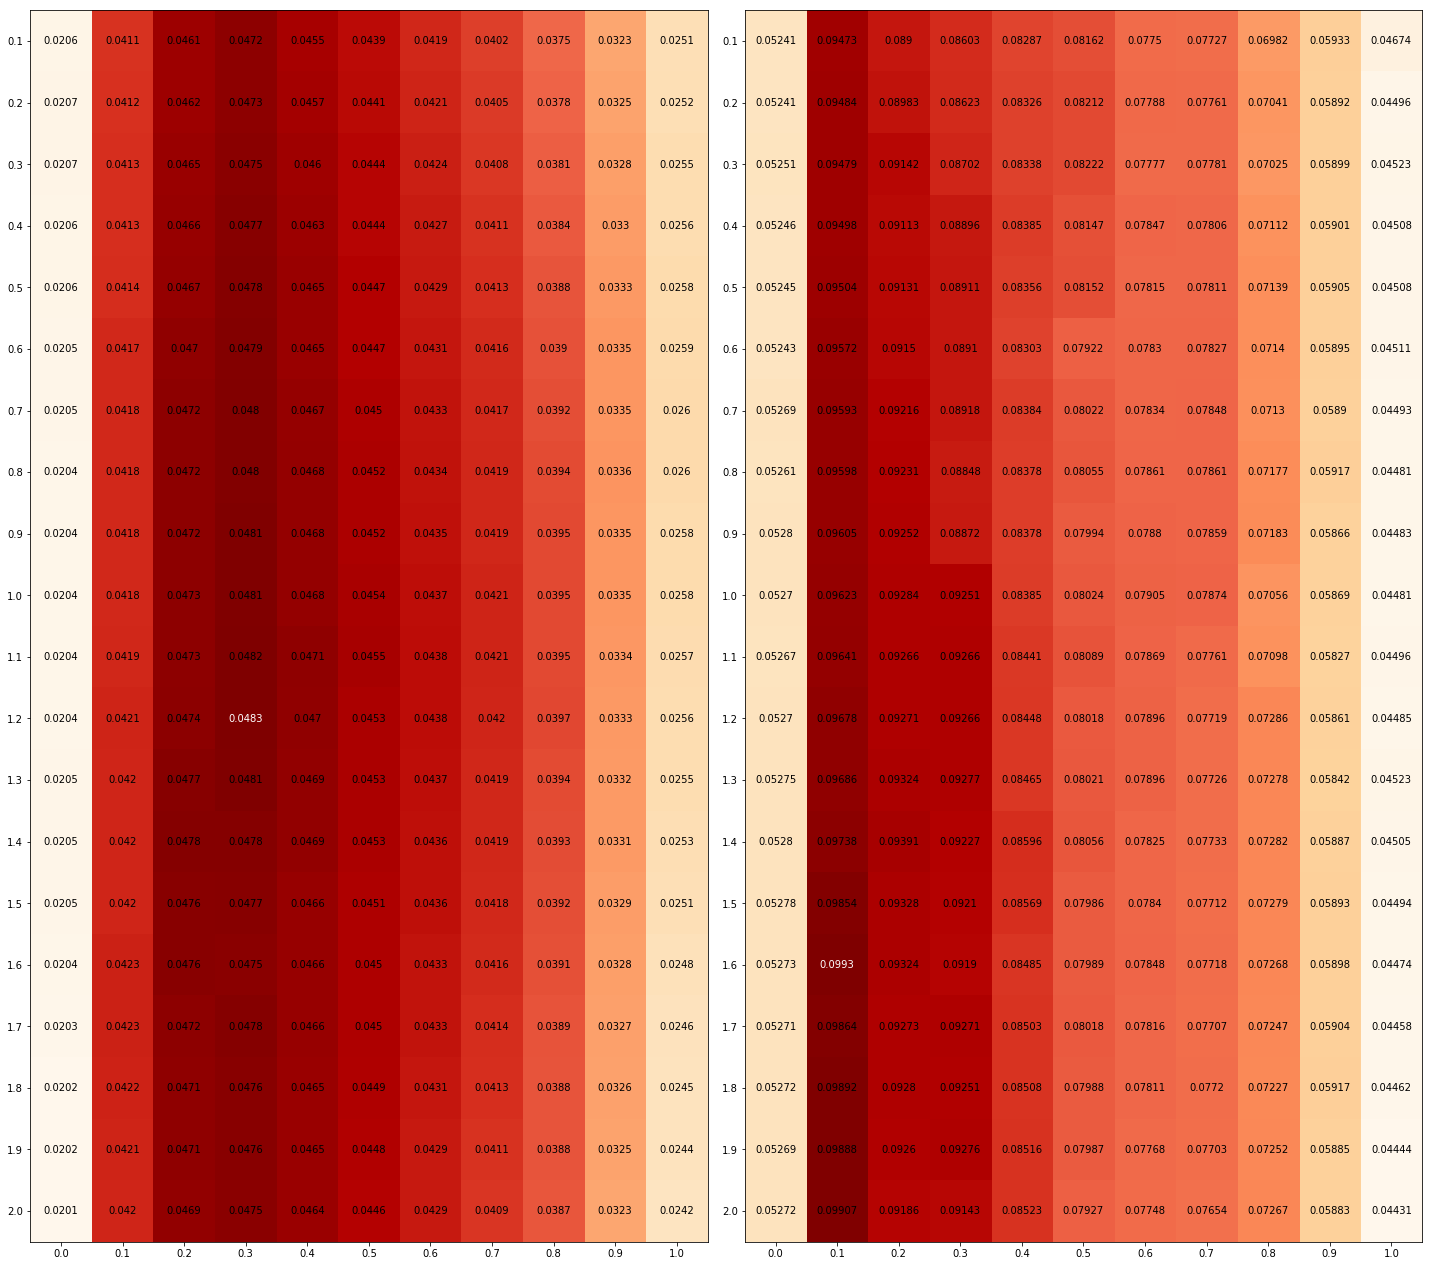

In [9]:
plot_metrics(df_bm25_train, bm25_params, [['map', 'ERR20']])

We can see that `map` is maximized at `k=1.2` and `b=0.3`. And `ERR20` is maximized at `k=1.6` and `b=0.1`.

In [10]:
df_bm25_test['ERR20'].loc[(df_bm25_test.k==1.6) & (df_bm25_test.b==0.1)]

215    0.10262
Name: ERR20, dtype: float64

In [11]:
df_bm25_test['ERR20'].loc[(df_bm25_test.k==1.2) & (df_bm25_test.b==0.3)]

101    0.11847
Name: ERR20, dtype: float64

# BM25 + RM3

In [12]:
rerank_params = ['k', 'b', 'fbt', 'fbd', 'w']
path_rm3 = Path('../results/bm25rm3/output')

df_rm3_train = to_df(path_rm3, '*201-250.txt', rerank_params)
df_rm3_test = to_df(path_rm3, '*251-300.txt', rerank_params)

In [13]:
df_rm3_train.groupby('k').describe()['ERR20']

,count,mean,std,min,25%,50%,75%,max
k,,,,,,,,
0.9,16.0,0.071989,0.005252,0.06419,0.067513,0.073420,0.075375,0.08258
1.2,80.0,0.073488,0.018554,0.00289,0.068748,0.075645,0.085612,0.09349
1.6,16.0,0.079386,0.006983,0.06549,0.075182,0.080215,0.086362,0.08779


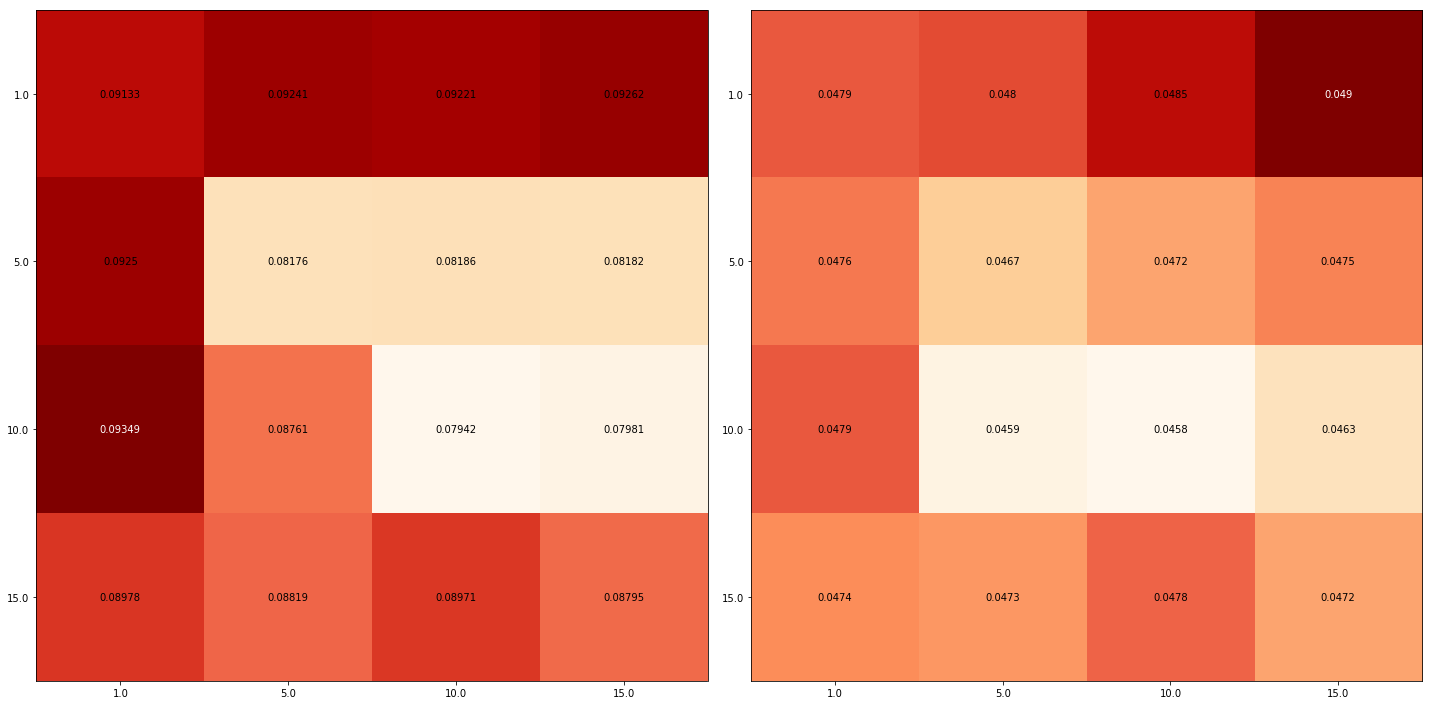

In [14]:
plot_metrics(df_rm3_train.loc[(df_rm3_train.k==1.2) & (df_rm3_train.w==0.9)], ['fbd', 'fbt'], [['ERR20', 'map']])

`ERR20` is maximized at `fbd=10`, `fbt=1`, `w=0.1` (`originalQueryWeight=0.9`)

In [15]:
df_rm3_test['ERR20'].loc[(df_rm3_test.k==1.2) & (df_rm3_test.b==0.3) & (df_rm3_test.fbd==10) & (df_rm3_test.fbt==1) & (df_rm3_test.w==0.9)]

10    0.12141
Name: ERR20, dtype: float64

# BM25PRF

In [16]:
path_prf = Path('../results/bm25prf/output')

df_prf_train = to_df(path_prf, '*201-250.txt', rerank_params)
df_prf_test = to_df(path_prf, '*251-300.txt', rerank_params)

In [17]:
df_prf_train.groupby('k').describe()['ERR20']

,count,mean,std,min,25%,50%,75%,max
k,,,,,,,,
0.9,80.0,0.084277,0.007970,0.06838,0.080015,0.08267,0.089715,0.10467
1.2,80.0,0.088977,0.009005,0.06807,0.083433,0.08980,0.094083,0.10944
1.6,80.0,0.089393,0.014361,0.05758,0.078162,0.09613,0.096770,0.11372


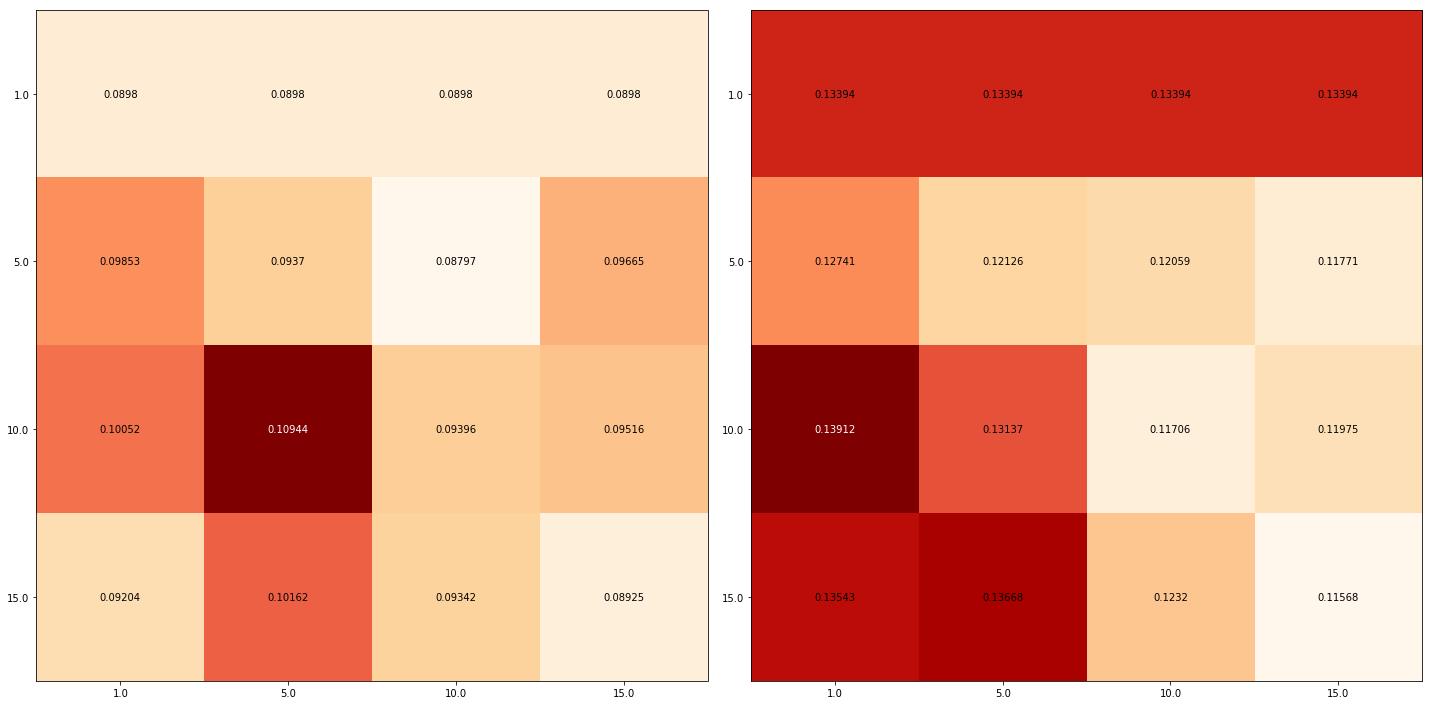

In [18]:
plot_metrics(df_prf_train.loc[(df_prf_train.k==1.2) & (df_prf_train.w==0.2)], ['fbd', 'fbt'], [['ERR20', 'NDCG20']])

`ERR20` is maximized when `fbd=10`, `fbt=5`, `w=0.2`

In [19]:
df_prf_test['ERR20'].loc[(df_prf_test.k==1.2) & (df_prf_test.b==0.3) & (df_prf_test.fbd==10) & (df_prf_test.fbt==5) & (df_prf_test.w==0.2)]

6    0.09636
Name: ERR20, dtype: float64